In [1]:
import numpy as np
import random
import time
from collections import namedtuple
import matplotlib
import matplotlib.pyplot as plt
#%matplotlib qt
import pickle

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
class line_world(): #fixed goal position
    def __init__(self):
        self.min_position = 0
        self.max_position = 3
        self.max_speed = 0.1
        
    def reset(self):
        self.state = np.random.rand(2)*(self.max_position-self.min_position)+self.min_position
        self.goal_position = np.random.rand(2)*(self.max_position-self.min_position)+self.min_position
        return self.state, self.goal_position
    
    def compute_reward(self):
        if np.sqrt(np.sum((self.state - self.goal_position)**2)) <= 0.05:
            reward = 100
            success = True
        else:
            reward = -1
            success = False
        return reward, success
    
    def step(self, action):
        action = action *self.max_speed
        self.state = np.clip(self.state + action, self.min_position, self.max_position)
        reward, success = self.compute_reward()
        
        return self.state, reward, success
        
    def render(self, t, i_episode):
        plt.figure(1)
        plt.clf()
        plt.xlim(self.min_position, self.max_position)
        plt.ylim(self.min_position, self.max_position)
        plt.plot(self.state[0], self.state[1], 'o', markersize=24, color='orange')
        plt.plot(self.goal_position[0], self.goal_position[1], 'o', markersize=24, color='green')
        plt.savefig('plots/live/'+str(i_episode)+'/live'+str(t)+'.png')

In [3]:
#REPLAY MEMORY

Transition = namedtuple('Transition', 
                        ('state', 'action', 'next_state', 'reward', 'goal'))

class ReplayMemory(object):
    
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
    
    def push(self, *args):
        '''Saves a transition.'''
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [4]:
class critic_network(nn.Module):
    
    def __init__(self, input_dim, output_dim, units=20):
        super(critic_network, self).__init__()
        self.layer1 = nn.Linear(input_dim, units)
        self.bn1 = nn.BatchNorm1d(units)
        self.layer2 = nn.Linear(units, units)
        self.bn2 = nn.BatchNorm1d(units)
        self.layer3 = nn.Linear(units, output_dim)   
        self.output_dim = output_dim
        
    def forward(self, x, debug=False):
        x = F.relu(self.layer1(x))#F.relu(self.bn1(self.layer1(x)))
        x = F.relu(self.layer2(x))#F.relu(self.bn2(self.layer2(x)))
        x = self.layer3(x)
        return x

In [5]:
class actor_network(nn.Module):
    
    def __init__(self, input_dim, output_dim, units=24):
        super(actor_network, self).__init__()
        self.layer1 = nn.Linear(input_dim, units)
        self.bn1 = nn.BatchNorm1d(units)
        self.layer2 = nn.Linear(units, units)
        self.bn2 = nn.BatchNorm1d(units)
        self.layer3 = nn.Linear(units, output_dim)
        
        self.tanh = nn.Tanh()
        
        self.output_dim = output_dim
        
    def forward(self, x, debug=False):
        x = F.relu(self.layer1(x))#F.relu(self.bn1(self.layer1(x)))
        x = F.relu(self.layer2(x))#F.relu(self.bn2(self.layer2(x)))  
        x = self.layer3(x)
        return self.tanh(x)

In [6]:
def weights_update(tau, target_network, network):
    for target_param, param in zip(target_network.parameters(), network.parameters()):
        target_param.data.copy_(tau*param.data + target_param.data*(1.0 - tau))

In [7]:
def compute_reward(new_state, goal):
    if torch.sqrt(torch.sum((new_state - goal)**2)) <= 0.05:
        reward = torch.tensor([100],dtype=torch.double)
    else:
        reward = torch.tensor([-1],dtype=torch.double)
    return reward

In [8]:
def plot_rewards(rewards):
    plt.figure(1)
    plt.clf()
    plt.title('Episode Reward')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.plot(rewards)
    plt.savefig('plots/rewards.png')
    
def plot_epoch_rewards(rewards):
    plt.figure(1)
    plt.clf()
    plt.title('Epoch Reward')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.plot(rewards)
    plt.savefig('plots/epoch_rewards.png')
    
def plot_epoch_success(epoch_successes):
    plt.figure(1)
    plt.clf()
    plt.title('Epoch Success Rate')
    plt.xlabel('Episode')
    plt.ylabel('Success Rate')
    plt.plot(epoch_successes)
    plt.savefig('plots/epoch_success.png')
    
def plot_success(successes):
    plt.figure(2)
    plt.clf()
    plt.title('Success Rate')
    plt.xlabel('Episode')
    plt.ylabel('Success Rate')
    plt.plot(successes)
    plt.savefig('plots/successes.png')
    
def plot_success_10(successes_raw):
    if len(successes_raw) >= 10:
        successes_raw = torch.tensor(successes_raw)
        successes_10 = successes_raw.unfold(0, 10, 1)
        successes_10 = successes_10.sum(1)/10
        successes_10 = successes_10.view(-1)
        means = torch.cat((torch.ones(9)*successes_10[0], successes_10))
        plt.figure(2)
        plt.clf()
        plt.title('Success Rate')
        plt.xlabel('Episode')
        plt.ylabel('Success Rate')
        plt.plot(means.numpy())
        plt.savefig('plots/successes_10.png')

def plot_rewards_10(successes_raw):
    if len(successes_raw) >= 10:
        successes_raw = torch.tensor(successes_raw)
        successes_10 = successes_raw.unfold(0, 10, 1)
        successes_10 = successes_10.sum(1)/10
        successes_10 = successes_10.view(-1)
        means = torch.cat((torch.ones(9, dtype=torch.double)*successes_10[0], successes_10))
        plt.figure(2)
        plt.clf()
        plt.title('Average Reward')
        plt.xlabel('Episode')
        plt.ylabel('Average Reward')
        plt.plot(means.numpy())
        plt.savefig('plots/reward_10.png')

def plot_qvalues(qvalues):
    plt.figure(3)
    plt.clf()
    plt.title('Q Values')
    plt.xlabel('Episode')
    plt.ylabel('Average Q Value')
    plt.plot(qvalues)
    plt.savefig('plots/qvalues.png')
    
def plot_losses(losses):
    plt.figure(4)
    plt.clf()
    plt.title('Loss')
    plt.xlabel('Episode')
    plt.ylabel('Loss')
    plt.plot(losses)
    plt.savefig('plots/losses.png')
    
def plot_Q(Q, goalx=1.5, goaly=1.5):
    plt.figure(5)
    plt.clf()
    Q_values = np.zeros((21,13))
    for i,x in enumerate(np.arange(0,3.25,.25)):
        for j,v in enumerate([-1,-.9,-.8,-.7,-.6,-.5,-.4,-.3,-.2,-.1,0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]):
            Q_values[j,i] = Q.forward(torch.tensor([x,goaly,v,0,goalx,goaly], dtype=torch.double, device=device))
    plt.imshow(Q_values, cmap ='bwr')
    plt.colorbar()
    plt.savefig('plots/Q_x_map'+str(goalx)+str(goaly)+'.png')
    
    plt.figure(5)
    plt.clf()
    Q_values = np.zeros((21,13))
    for i,y in enumerate(np.arange(0,3.25,.25)):
        for j,v in enumerate([-1,-.9,-.8,-.7,-.6,-.5,-.4,-.3,-.2,-.1,0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]):
            Q_values[j,i] = Q.forward(torch.tensor([goalx,y,0,v,goalx,goaly], dtype=torch.double, device=device))
    plt.imshow(Q_values, cmap ='bwr')
    plt.colorbar()
    plt.savefig('plots/Q_y_map'+str(goalx)+str(goaly)+'.png')
    
    plt.figure(5)
    plt.clf()
    Q_values = np.zeros((13,13))
    for i,x in enumerate(np.arange(0,3.25,.25)):
        for j,y in enumerate(np.arange(0,3.25,.25)):
            Q_values[j,i] = Q.forward(torch.tensor([x,y,0,0,goalx,goaly], dtype=torch.double, device=device))
    plt.imshow(Q_values, cmap ='bwr', extent=[0,1,1,0])
    plt.colorbar()
    plt.savefig('plots/Q/Q_x_y_map_v0_goal'+str(goaly)+str(goalx)+str(i_episode)+'.png')

def plot_mu(mu, goalx=1.5, goaly=1.5):
    plt.figure(6)
    plt.clf()
    mu_values_x = np.zeros((13,13))
    mu_values_y = np.zeros((13,13))
    for i,x in enumerate(np.arange(0,3.25,.25)):
        for j,y in enumerate(np.arange(0,3.25,.25)):
            mu_val = mu.forward(torch.tensor([x,y,goalx,goaly], dtype=torch.double, device=device))
            mu_values_x[j,i] = mu_val[0]
            mu_values_y[j,i] = mu_val[1]
    plt.imshow(mu_values_x, cmap='bwr')
    plt.colorbar()
    plt.savefig('plots/mu_x_map_constgoal.png')
    
    plt.imshow(mu_values_y, cmap='bwr')
    plt.savefig('plots/mu_y_map_constgoal.png')
    
    mu_values = np.zeros((13,13))
    for i,x in enumerate(np.arange(0,3.25,.25)):
        for j,goalx in enumerate(np.arange(0,3.2,.251)):
            mu_val = mu.forward(torch.tensor([x,goaly,goalx,goaly], dtype=torch.double, device=device))
            mu_values[j,i] = mu_val[0]
    plt.imshow(mu_values, cmap='bwr')
    plt.savefig('plots/mu_x_map_consty.png')
    
    mu_values = np.zeros((13,13))
    for i,y in enumerate(np.arange(0,3.25,.25)):
        for j,goaly in enumerate(np.arange(0,3.25,.25)):
            mu_val = mu.forward(torch.tensor([goalx,y,goalx,goaly], dtype=torch.double, device=device))
            mu_values[j,i] = mu_val[1]
    plt.imshow(mu_values, cmap='bwr')
    plt.savefig('plots/mu_y_map_constx.png')


In [9]:
def optimize_model():
    if len(R) < BATCH_SIZE:
        return 0,0
   
    # sample a random minibatch of N transitions (si, ai, ri, si+1) from R
    transitions = R.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))
        
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    next_state_batch = torch.cat(batch.next_state)
    reward_batch = torch.cat(batch.reward)
    goal_batch = torch.cat(batch.goal)
  
    with torch.no_grad():
        # set yi = ri + gamma*Q'(si+1,mu'(si+1))
        target_actions = target_mu(torch.cat((next_state_batch, goal_batch),1))
        y = reward_batch.view(BATCH_SIZE,1) + GAMMA*target_Q(torch.cat((next_state_batch, target_actions, goal_batch),1))
        
    
    # update critic by minimizing the MSE loss = 1/m sum (y - Q(si,ai))^2
    Q.train()
    Q_optimizer.zero_grad()    
    q = Q(torch.cat((state_batch, action_batch, goal_batch),1))
    loss = ((y-q)**2).mean()   
    loss.backward()
    Q_optimizer.step()
    
 
    # update the actor policy using the sampled policy gradient
    #gradient_mu = 1/N sum gradient(Q(si,mu(si)) wrt mu(si)) * gradient(mu(si), wrt mu.weights)
   
    mu.train()
    mu_optimizer.zero_grad()
    actions = mu(torch.cat((state_batch, goal_batch), 1))
    values = Q(torch.cat((state_batch, actions, goal_batch),1))
    mean_target_values = -values.mean()
    mean_target_values.backward()
    mu_optimizer.step()
    
    # update target networks
    #target_Q.weights = tau*target_Q.weights + (1-tau)*Q.weights
    #target_mu.weights = tau*target_mu + (1-tau)*mu.weights
    weights_update(TAU, target_Q, Q)
    weights_update(TAU, target_mu, mu)
    return mean_target_values, loss

In [10]:
BATCH_SIZE = 256
EPSILON = 1
EPSILON_DECAY = 0.999
EPSILON_MIN = 0.05
GAMMA = 0.999
TAU = 0.0000001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [11]:
def compute_epoch_avg():
    epoch_reward = 0
    success_rate = 0
    
    for i in range(50):
        # receive initial observation state s1
        episode_reward = 0
        state, goal = env.reset()
        goal = torch.tensor([goal], dtype=torch.double)
        state = torch.tensor([state], dtype=torch.double)
        t = 0
        while t < 700:
            t += 1
            #env.render()
                
            # select action  
            #if i_episode % 10 != 0 or i_episode == 0:
            action = mu.forward(torch.cat((state, goal),1))

            # execute action at and observe reward rt and observe new state st+1

            next_state, reward, success = env.step(action.detach().numpy()[0,0])
            next_state = torch.tensor([next_state], dtype=torch.double, device=device)

            # move to the next state
            state = next_state

            episode_reward = episode_reward+ reward

            if success:
                success_rate += 1
                print('SUCCESS')
                print(goal)
                print(state)
                break
        epoch_reward += episode_reward

    return epoch_reward/50, success_rate/50
    

In [12]:
def pick_new_goal(R_episode, strategy = 'final'):
    
    if strategy == 'final':
        new_goal = episode_R.memory[episode_R.position-1].state
        return new_goal
    
    elif strategy == 'future':
        new_goal = random.sample(episode_R.memory[:], 1)[0].state
        return new_goal
        
    elif strategy == 'maximize':
        
        states = torch.cat([x.state for x in episode_R.memory[:]])
        next_states = torch.cat([x.next_state for x in episode_R.memory[:]])
        actions = torch.cat([x.action for x in episode_R.memory[:]])
        possible_goals = [x.state for x in episode_R.memory[:]]#random.sample(episode_R.memory[:], 5)]
        errors = []
        
        # compute bellman error
        with torch.no_grad():
            for goal in possible_goals:
                goal_tensor = torch.cat([goal]*len(states))
                rewards = torch.sqrt(torch.sum((states - goal_tensor)**2,1))                
                rewards[rewards>0.05] = 1
                rewards[rewards<=0.05] = -1100
               
                 # set yi = ri + gamma*Q'(si+1,mu'(si+1))
                target_actions = target_mu(torch.cat((next_states, goal_tensor),1))
                y = rewards + GAMMA*target_Q(torch.cat((next_states, target_actions, goal_tensor),1))
                
                q = Q(torch.cat((states, actions, goal_tensor),1))

                error = ((y-q)**2).mean().detach().item()
                errors.append(error)
            
            # select maximal error
            return possible_goals[np.argmax(errors)]
        

SUCCESS
tensor([[0.0951, 0.2963]], dtype=torch.float64)
tensor([[0.0471, 0.3092]], dtype=torch.float64)
SUCCESS
tensor([[1.4803, 0.5041]], dtype=torch.float64)
tensor([[1.4699, 0.5471]], dtype=torch.float64)
SUCCESS
tensor([[2.5764, 0.9177]], dtype=torch.float64)
tensor([[2.6072, 0.8789]], dtype=torch.float64)
SUCCESS
tensor([[1.7771, 0.2430]], dtype=torch.float64)
tensor([[1.7507, 0.2737]], dtype=torch.float64)
SUCCESS
tensor([[1.9954, 2.3925]], dtype=torch.float64)
tensor([[2.0200, 2.4148]], dtype=torch.float64)
SUCCESS
tensor([[0.2147, 0.0000]], dtype=torch.float64)
tensor([[0.1892, 0.0244]], dtype=torch.float64)
SUCCESS
tensor([[2.4534, 0.2375]], dtype=torch.float64)
tensor([[2.4368, 0.2340]], dtype=torch.float64)
SUCCESS
tensor([[1.6604, 2.4993]], dtype=torch.float64)
tensor([[1.7005, 2.5247]], dtype=torch.float64)
SUCCESS
tensor([[0.9586, 2.5687]], dtype=torch.float64)
tensor([[0.9630, 2.5399]], dtype=torch.float64)
SUCCESS
tensor([[2.1807, 2.2846]], dtype=torch.float64)
tensor([

SUCCESS
tensor([[0.3656, 0.6966]], dtype=torch.float64)
tensor([[0.3714, 0.6631]], dtype=torch.float64)
SUCCESS
tensor([[0.0670, 2.6093]], dtype=torch.float64)
tensor([[0.0330, 2.6194]], dtype=torch.float64)
SUCCESS
tensor([[2.0661, 2.4308]], dtype=torch.float64)
tensor([[2.1005, 2.4176]], dtype=torch.float64)
SUCCESS
tensor([[2.6210, 2.2948]], dtype=torch.float64)
tensor([[2.5749, 2.2761]], dtype=torch.float64)
SUCCESS
tensor([[0.7316, 2.8089]], dtype=torch.float64)
tensor([[0.7305, 2.8296]], dtype=torch.float64)
SUCCESS
tensor([[1.4101, 1.6060]], dtype=torch.float64)
tensor([[1.3925, 1.5741]], dtype=torch.float64)
SUCCESS
tensor([[2.9339, 0.9999]], dtype=torch.float64)
tensor([[2.9755, 0.9849]], dtype=torch.float64)
SUCCESS
tensor([[1.7911, 2.1504]], dtype=torch.float64)
tensor([[1.7469, 2.1320]], dtype=torch.float64)
SUCCESS
tensor([[0.6883, 2.6477]], dtype=torch.float64)
tensor([[0.6706, 2.6682]], dtype=torch.float64)
SUCCESS
tensor([[1.9702, 2.5698]], dtype=torch.float64)
tensor([

SUCCESS
tensor([[2.9411, 2.6163]], dtype=torch.float64)
tensor([[2.9587, 2.5802]], dtype=torch.float64)
SUCCESS
tensor([[0.2916, 2.1023]], dtype=torch.float64)
tensor([[0.3123, 2.0576]], dtype=torch.float64)
SUCCESS
tensor([[1.2395, 0.1390]], dtype=torch.float64)
tensor([[1.2237, 0.1352]], dtype=torch.float64)
SUCCESS
tensor([[0.1095, 0.1793]], dtype=torch.float64)
tensor([[0.1138, 0.1755]], dtype=torch.float64)
SUCCESS
tensor([[0.1777, 0.4893]], dtype=torch.float64)
tensor([[0.2066, 0.5211]], dtype=torch.float64)
SUCCESS
tensor([[0.1070, 2.3125]], dtype=torch.float64)
tensor([[0.0943, 2.3573]], dtype=torch.float64)
SUCCESS
tensor([[2.8182, 2.1433]], dtype=torch.float64)
tensor([[2.8066, 2.1604]], dtype=torch.float64)
SUCCESS
tensor([[1.2846, 0.0426]], dtype=torch.float64)
tensor([[1.3037, 0.0061]], dtype=torch.float64)
SUCCESS
tensor([[0.4725, 0.1939]], dtype=torch.float64)
tensor([[0.4684, 0.1605]], dtype=torch.float64)
SUCCESS
tensor([[1.4296, 2.1844]], dtype=torch.float64)
tensor([

SUCCESS
tensor([[1.2604, 1.8344]], dtype=torch.float64)
tensor([[1.2119, 1.8413]], dtype=torch.float64)
SUCCESS
tensor([[0.5706, 1.6783]], dtype=torch.float64)
tensor([[0.5524, 1.7059]], dtype=torch.float64)
SUCCESS
tensor([[2.1040, 0.8238]], dtype=torch.float64)
tensor([[2.1476, 0.8222]], dtype=torch.float64)
SUCCESS
tensor([[2.6610, 1.0521]], dtype=torch.float64)
tensor([[2.6767, 1.0728]], dtype=torch.float64)
SUCCESS
tensor([[1.5750, 2.8169]], dtype=torch.float64)
tensor([[1.5796, 2.8446]], dtype=torch.float64)
SUCCESS
tensor([[0.5397, 2.9660]], dtype=torch.float64)
tensor([[0.5573, 2.9443]], dtype=torch.float64)
SUCCESS
tensor([[1.1430, 1.7937]], dtype=torch.float64)
tensor([[1.1137, 1.7892]], dtype=torch.float64)
SUCCESS
tensor([[2.1456, 1.2149]], dtype=torch.float64)
tensor([[2.1541, 1.2363]], dtype=torch.float64)
SUCCESS
tensor([[2.8377, 1.4430]], dtype=torch.float64)
tensor([[2.8699, 1.4615]], dtype=torch.float64)
SUCCESS
tensor([[1.4227, 2.7447]], dtype=torch.float64)
tensor([

KeyboardInterrupt: 

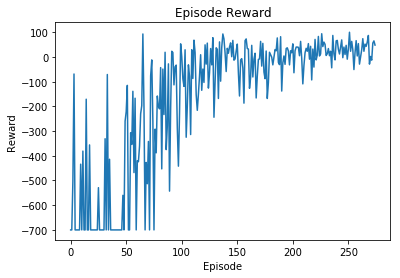

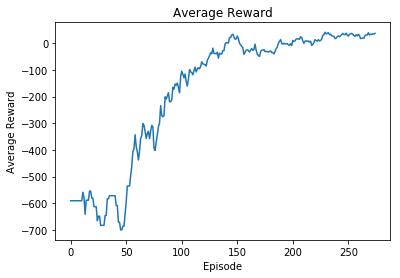

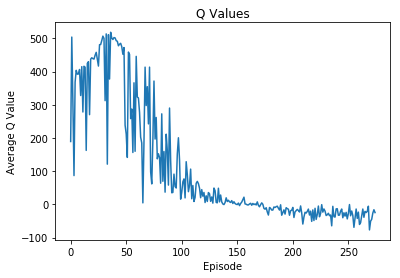

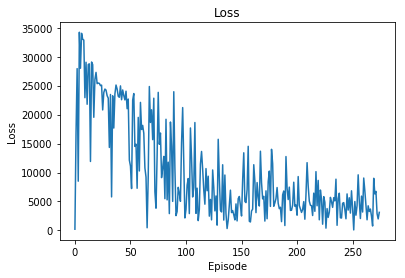

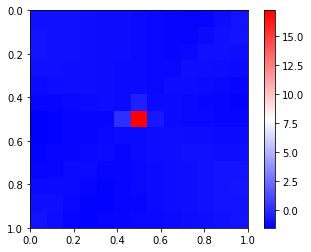

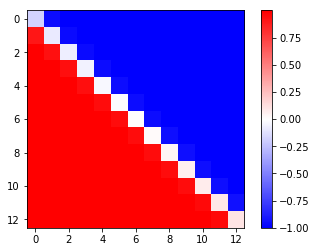

In [13]:
#WITH HINDSIGHT EXPERIENCE REPLAY

np.random.seed(0)
torch.manual_seed(0)

epoch_rewards = []
epoch_successes = []
rewards = []
successes = []
success_rate = 0
successes_raw = []
losses = []
qvalues = []

# randomly initialize critic network Q and actor mu
Q = critic_network(input_dim=6, output_dim=1).double().to(device)
mu = actor_network(input_dim=4, output_dim=2).double().to(device)

# create optimizers
Q_optimizer = optim.Adam(Q.parameters(), lr=0.0001)
mu_optimizer = optim.Adam(mu.parameters(), lr=0.00001)

# initialize target critic network Q' and target actor network mu' with same weights as Q and mu
target_Q = critic_network(input_dim=6, output_dim=1).double().to(device)
weights_update(1, target_Q, Q)
for p in target_Q.parameters():
        p.requires_grad = False

target_mu = actor_network(input_dim=4, output_dim=2).double().to(device)
weights_update(1, target_mu, mu)
for p in target_mu.parameters():
        p.requires_grad = False
        
# initialize replay buffer R
R = ReplayMemory(1000000) # size of replay buffer is 10^6


env = line_world() # set environment here
for i_episode in range(3000):
    episode_reward = 0
    episode_qval = 0
    episode_loss = 0
    episode_R = ReplayMemory(500)    
    
    # receive initial observation state s1
    state, goal = env.reset()
    state = torch.tensor([state], dtype=torch.double)
    goal = torch.tensor([goal], dtype=torch.double)
    t = 0
    while t < 700:
        t += 1
        
        #if i_episode % 10 == 0:
        #    env.render(t,i_episode)
        
        # select action  
        #if i_episode % 10 != 0 or i_episode == 0:
        action = mu.forward(torch.cat((state, goal),1))
        #if i_episode % 10 != 0 and i_episode != 0: # test policy with  no noise every tenth epoch
        if np.random.rand(1) < (EPSILON):
            #if np.random.rand(1) < (1-t/100):
            action = torch.tensor([np.random.rand(2)*2-1], dtype=torch.double)
            #action += 2*torch.tensor([np.random.randn(1)], dtype=torch.double)
        action = torch.clamp(action, -1, 1)
        
        # execute action at and observe reward rt and observe new state st+1
    
        next_state, reward, success = env.step(action.detach().numpy()[0])
        reward = torch.tensor([[reward]], dtype=torch.double, device=device)
        next_state = torch.tensor([next_state], dtype=torch.double, device=device)
        action = action.detach()
        
        # store transition (st, at, st+1, rt) in R
        R.push(state, action, next_state, reward, goal)
        episode_R.push(state, action, next_state, reward, goal)
            
        # move to the next state
        state = next_state
        
        #if i_episode % 10 != 0:
        qval, loss = optimize_model()
        episode_qval += qval
        episode_loss += loss
        
        episode_reward = episode_reward+ reward
        
        
        if success:
            success_rate += 1
            print('SUCCESS')
            print(state)
            print(goal)
            break
            
    new_goal = pick_new_goal(episode_R, strategy='final') 
    for i in range(episode_R.position):
        state = episode_R.memory[i].state
        action = episode_R.memory[i].action
        next_state = episode_R.memory[i].next_state
        reward = compute_reward(next_state, new_goal)        
        reward = reward.unsqueeze(0)
        R.push(state, action, next_state, reward, new_goal)
            
   
    if EPSILON > EPSILON_MIN:
        EPSILON *= EPSILON_DECAY
    # plot rewards
    if i_episode % 10 == 0:
        epoch_avg_reward, epoch_success = compute_epoch_avg()
        epoch_rewards.append(epoch_avg_reward)
        epoch_successes.append(epoch_success)
        plot_epoch_rewards(epoch_rewards)
        plot_epoch_success(epoch_successes)
    
    if success:        
        successes_raw.append(1.0)
    else:
        successes_raw.append(0.0)
        
    successes.append(success_rate/(i_episode+1))
    rewards.append(episode_reward)
    qvalues.append(episode_qval)
    losses.append(episode_loss)
    plot_success(successes)
    plot_success_10(successes_raw)
    plot_rewards_10(rewards)
    plot_rewards(rewards)
    plot_qvalues(qvalues)
    plot_losses(losses)
    plot_Q(Q)
    plot_mu(mu)
    pickle.dump(successes, open('plots/successes.p', 'wb'))
    #plot_Q(Q, goalx=2,goaly=2)
    #plot_Q(Q, goalx=1,goaly=1)
        

In [ ]:
torch.sqrt(torch.sum(torch.tensor([[1.0,2.0],[2.0,3.0],[3.0,4.0]]),1))

In [14]:
torch.save(Q.state_dict(), 'plots/Q.pt')
torch.save(target_Q.state_dict(), 'plots/target_Q.pt')
torch.save(mu.state_dict(), 'plots/mu.pt')
torch.save(target_mu.state_dict(), 'plots/target_mu.pt')

KeyboardInterrupt: 

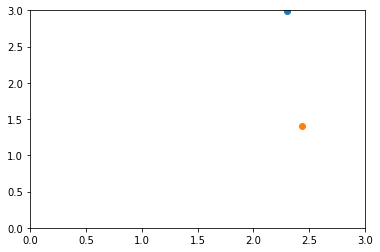

In [66]:
compute_epoch_avg()

In [17]:
pickle.dump(successes, open('plots/successes.p', 'wb'))
pickle.dump(successes_raw, open('plots/successes_raw.p','wb'))
pickle.dump(rewards, open('plots/rewards.p', 'wb'))
pickle.dump(epoch_rewards, open('plots/epoch_rewards.p', 'wb'))
pickle.dump(epoch_successes, open('plots/epoch_successes.p', 'wb'))

In [55]:
successes_raw = torch.tensor([1.0,1,0,1,1,0,0,0,0,0,0,0])
successes_10 = successes_raw.unfold(0, 3, 1)
print(successes_10)
successes_10 = successes_10.sum(1)/3
print(successes_10)
successes_10 = successes_10.view(-1)
print(successes_10)
means = torch.cat((torch.ones(9)*successes_10[0], successes_10))
print(means)

tensor([[1., 1., 0.],
        [1., 0., 1.],
        [0., 1., 1.],
        [1., 1., 0.],
        [1., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])
tensor([0.6667, 0.6667, 0.6667, 0.6667, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000])
tensor([0.6667, 0.6667, 0.6667, 0.6667, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000])
tensor([0.6667, 0.6667, 0.6667, 0.6667, 0.6667, 0.6667, 0.6667, 0.6667, 0.6667,
        0.6667, 0.6667, 0.6667, 0.6667, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000])


In [16]:
rewards

[tensor([[-700.]], dtype=torch.float64),
 tensor([[-700.]], dtype=torch.float64),
 tensor([[-503.]], dtype=torch.float64),
 tensor([[-69.]], dtype=torch.float64),
 tensor([[-700.]], dtype=torch.float64),
 tensor([[-700.]], dtype=torch.float64),
 tensor([[-700.]], dtype=torch.float64),
 tensor([[-700.]], dtype=torch.float64),
 tensor([[-700.]], dtype=torch.float64),
 tensor([[-434.]], dtype=torch.float64),
 tensor([[-700.]], dtype=torch.float64),
 tensor([[-381.]], dtype=torch.float64),
 tensor([[-700.]], dtype=torch.float64),
 tensor([[-700.]], dtype=torch.float64),
 tensor([[-171.]], dtype=torch.float64),
 tensor([[-700.]], dtype=torch.float64),
 tensor([[-700.]], dtype=torch.float64),
 tensor([[-356.]], dtype=torch.float64),
 tensor([[-700.]], dtype=torch.float64),
 tensor([[-700.]], dtype=torch.float64),
 tensor([[-700.]], dtype=torch.float64),
 tensor([[-700.]], dtype=torch.float64),
 tensor([[-700.]], dtype=torch.float64),
 tensor([[-700.]], dtype=torch.float64),
 tensor([[-700.]]